# Conic Non-linear optimization

Description todo

Basic idea: in part (1) we discussed how to use callbacks to solve IPs.
In part (2) we will cover how to solve NLPs
In part (3) we will combine parts (1)-(2) to do something cool.

Credit: some of this material is adapted from the 2016 version of this course, written by Miles Lubin and Yeesian Ng.

In [1]:
using Mosek #,Gurobi

# Part 1: SVM's
Support Vector Machines are a popular model in machine learning for classification. We'll use this example to illustrate the basic use of JuMP.jl for solving nontrivial conic optimization problems.

Specifically, we are going to build our own custom svm solver, so that we can constraints which off-the-shelf SVM solvers can't handle.

The basic problem is that we are given a set of N points $x_1,x_2,\ldots, x_N \in \mathbb{R}^n$ and labels $y_1, y_2, \ldots, y_n \in \{-1,+1\}$. And we want to find a hyperplane of the form $w^Tx-b = 0$ that separates the two classes, i.e. $w^Tx_i - b \geq 1$ when $y_i = +1$ and $w^Tx_i - b \leq -1$ when $y_i = -1$. This condition can be written as $y_i(w^Tx_i - b) \geq 1, \forall\, i$.

Such a hyperplane will not exist in general if the data overlap, so instead we'll just try to minimize violations of the constraint $y_i(w^Tx_i - b) \geq 1, \forall\, i$ by adding a penalty when it is violated. The optimization problem can be stated as $$
\min_{w,b} \sum_{i=1}^N \left[\max\{0, 1 - y_i(w^Tx_i - b)\}\right] + \gamma ||w||_2^2
$$ Note that we penalize the norm of $w$ in order to guarantee a unique solution.

Now let's write our own SVM solver!

In [7]:
#Pkg.add("PyPlot")
using Mosek #, Pick your favourite solver here e.g. CPLEX/Gurobi. Note that you need to install Mosek to use it
using Distributions
using PyPlot

In [8]:
# Function to generate some random test data
function gen_data(N)
    # for +1 data, symmetric multivariate normal with center at (1,2)
    pos = rand(MvNormal([1.0,2.0],1.0),N)
    # for -1 data, symmetric multivariate normal with center at (-1,1)
    neg = rand(MvNormal([-3.0,1.0],1.0),N)
    x = [pos neg]
    y = [fill(+1,N);fill(-1,N)]
    return x,y
end

gen_data (generic function with 1 method)

Let's see what the data look like.

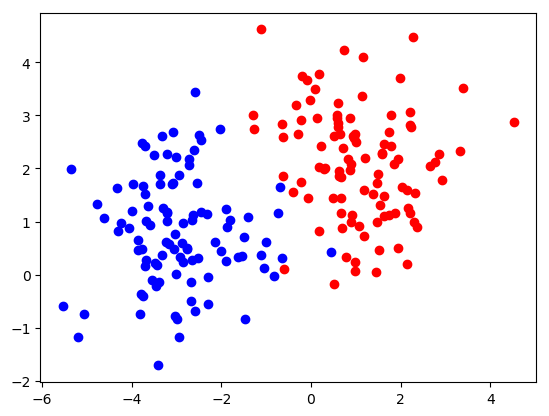

In [9]:
x,y = gen_data(100)
plot(x[1,1:100], x[2,1:100], "ro", x[1,101:200], x[2,101:200], "bo");

Now we translate the optimization problem into JuMP form.

In [28]:
using JuMP
const γ = 0.005
function svm(x,y)
    n = size(x,1) # problem dimension
    N = size(x,2) # number of points
    svmModel=Model(solver=MosekSolver()) #Change to the solver you are using
    @variable(svmModel, w[1:n])
    @variable(svmModel, b)
    @variable(svmModel, z[1:N]>=0)


    @constraint(svmModel,z.>=ones(N)-y.*(x'*w-b))
    @objective(svmModel, Min, γ*w'*w+sum(z))
    
    status=solve(svmModel)
    return getvalue(w), getvalue(b)
end

svm (generic function with 1 method)

In [29]:
N = 500
x,y = gen_data(N)

w,b = svm(x,y)

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : QO (quadratic optimization problem)
  Constraints            : 1000            
  Cones                  : 0               
  Scalar variables       : 1003            
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Quadratic to conic reformulation started.
Quadratic to conic reformulation terminated. Time: 0.00    
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.01    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   

([2.16569, 0.641245], -1.1451882689005672)

And the solution?

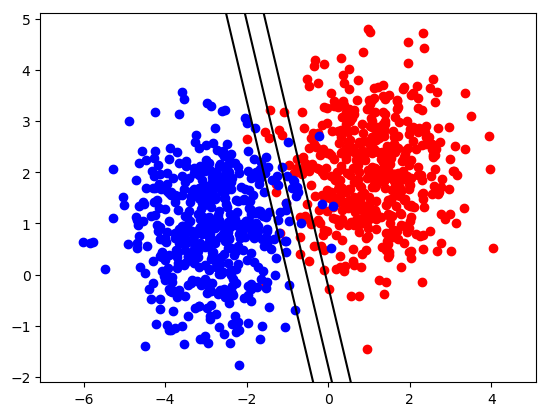

In [30]:
plot(x[1,1:N], x[2,1:N], "ro", x[1,(N+1):2N], x[2,(N+1):2N], "bo");

xmin, xmax = xlim()
ymin, ymax = ylim()
y1 = (1+b-w[1]*xmin)/w[2]
y2 = (1+b-w[1]*xmax)/w[2]
plot([xmin,xmax], [y1,y2], "k-");
y1 = (-1+b-w[1]*xmin)/w[2]
y2 = (-1+b-w[1]*xmax)/w[2]
plot([xmin,xmax], [y1,y2], "k-");
y1 = (b-w[1]*xmin)/w[2]
y2 = (b-w[1]*xmax)/w[2]
ylim(ymin,ymax)
plot([xmin,xmax], [y1,y2], "k-");

# Exercise: how would you cross-validate $\gamma$?
Also discuss what changes to this code you would make, to make your code scale.